In [1]:
import numpy as np
from scipy import linalg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pg_fitter_tools as fit
import cv2

In [2]:
%matplotlib notebook

In [3]:
focal_length = [2.760529621789217e+03, 2.767014510543478e+03]
principle_point = [1.914303537872458e+03, 1.596386868474348e+03]
radial_distortion = [0, 0]
tangential_distortion = [0, 0]

In [4]:
# rotate about z so that light injectors are in +y dir and tank axis remains +z dir
theta = np.pi/2-np.arctan(768.14 / 1490.73)
rot2 = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]])
# rotate about x so that light injectors are in +z dir and tank axis is -y dir
# (in image coords, +y is directed down)
rot1 = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
rot = np.matmul(rot1, rot2)
camera_rotation = cv2.Rodrigues(rot)[0]
camera_r = 1300.
camera_spacing = 120.
camera_translations = np.array([
    [0., 424.+camera_spacing*0, -camera_r],
    [0., 424.+camera_spacing*1, -camera_r],
    [0., 424.+camera_spacing*2, -camera_r],
    [0., 424.+camera_spacing*3, -camera_r],
    [0., 424.+camera_spacing*4, -camera_r],
    [0., 424.+camera_spacing*5, -camera_r],
    [0., 424.+camera_spacing*6, -camera_r],
    [0., 424.+camera_spacing*7, -camera_r],
    [0., 424.+camera_spacing*8, -camera_r],
    [0., 424.+camera_spacing*9, -camera_r]
])

In [5]:
pmt_locations = fit.read_3d_feature_locations("SK_simtest_PMT_locations.txt", delimiter=" ")

In [6]:
nimages = len(camera_translations)
nfeatures = len(pmt_locations)

In [7]:
image_feature_locations = {
    i : {list(pmt_locations.keys())[f]:v for f, v in enumerate(
        cv2.projectPoints(np.array(list(pmt_locations.values())), camera_rotation, t,
                          fit.build_camera_matrix(focal_length, principle_point), np.zeros(4))[0].reshape((-1,2)))
         if v[1] > 0 and v[1] < 3000
        }
    for i, t in enumerate(camera_translations)
}

In [8]:
# delete features that don't appear in all images

#common_features = set.intersection(*[set(i) for i in image_feature_locations.values()])
#for k, i in image_feature_locations.items():
#    image_feature_locations[k] = {j: f for j, f in i.items() if j in common_features}
#pmt_locations = {k: v for k, v in pmt_locations.items() if k in common_features}

In [9]:
for k, i in image_feature_locations.items():
    for j, f in i.items():
        image_feature_locations[k][j] = np.random.normal(f, 1)

In [10]:
fitter = fit.PhotogrammetryFitter(image_feature_locations, pmt_locations, focal_length, principle_point)

In [11]:
camera_rotations, camera_translations = fitter.estimate_camera_poses()

image 0 reprojection errors:    average: 1.250048843600398    max: 2.608995964150936
image 1 reprojection errors:    average: 1.1965736044920072    max: 2.3172258224248927
image 2 reprojection errors:    average: 1.0788051546299577    max: 2.450756734669792
image 3 reprojection errors:    average: 1.1173452288369132    max: 2.87958854200917
image 4 reprojection errors:    average: 1.2971666826116728    max: 2.8274797472872675
image 5 reprojection errors:    average: 1.1536227183086492    max: 2.3766418386389376
image 6 reprojection errors:    average: 1.2095738326849512    max: 2.520008458966691
image 7 reprojection errors:    average: 1.026026679540206    max: 2.5489787010037928
image 8 reprojection errors:    average: 1.2454851044505906    max: 2.9099391070164202
image 9 reprojection errors:    average: 1.1226856162554428    max: 2.3291352400490957


In [12]:
camera_rotations, camera_translations, reco_locations = fitter.bundle_adjustment(camera_rotations, camera_translations)

`ftol` termination condition is satisfied.
Function evaluations 2537, initial cost 2.8759e+02, final cost 1.3026e+02, first-order optimality 5.94e-02.
mean reprojection error: 0.7569701667257457
max reprojection error: 2.003591173468641


In [13]:
errors, reco_transformed, scale, R, translation = fit.kabsch_errors(
    pmt_locations, reco_locations)
print("mean reconstruction error:", linalg.norm(errors, axis=1).mean())
print("max reconstruction error:", linalg.norm(errors, axis=1).max())

mean reconstruction error: 0.3828953867851658
max reconstruction error: 1.2705109582050549


In [14]:
camera_orientations, camera_positions = fit.camera_world_poses(camera_rotations, camera_translations)
camera_orientations = np.matmul(R, camera_orientations)
camera_positions = camera_positions - translation
camera_positions = scale*R.dot(camera_positions.transpose()).transpose()

<IPython.core.display.Javascript object>


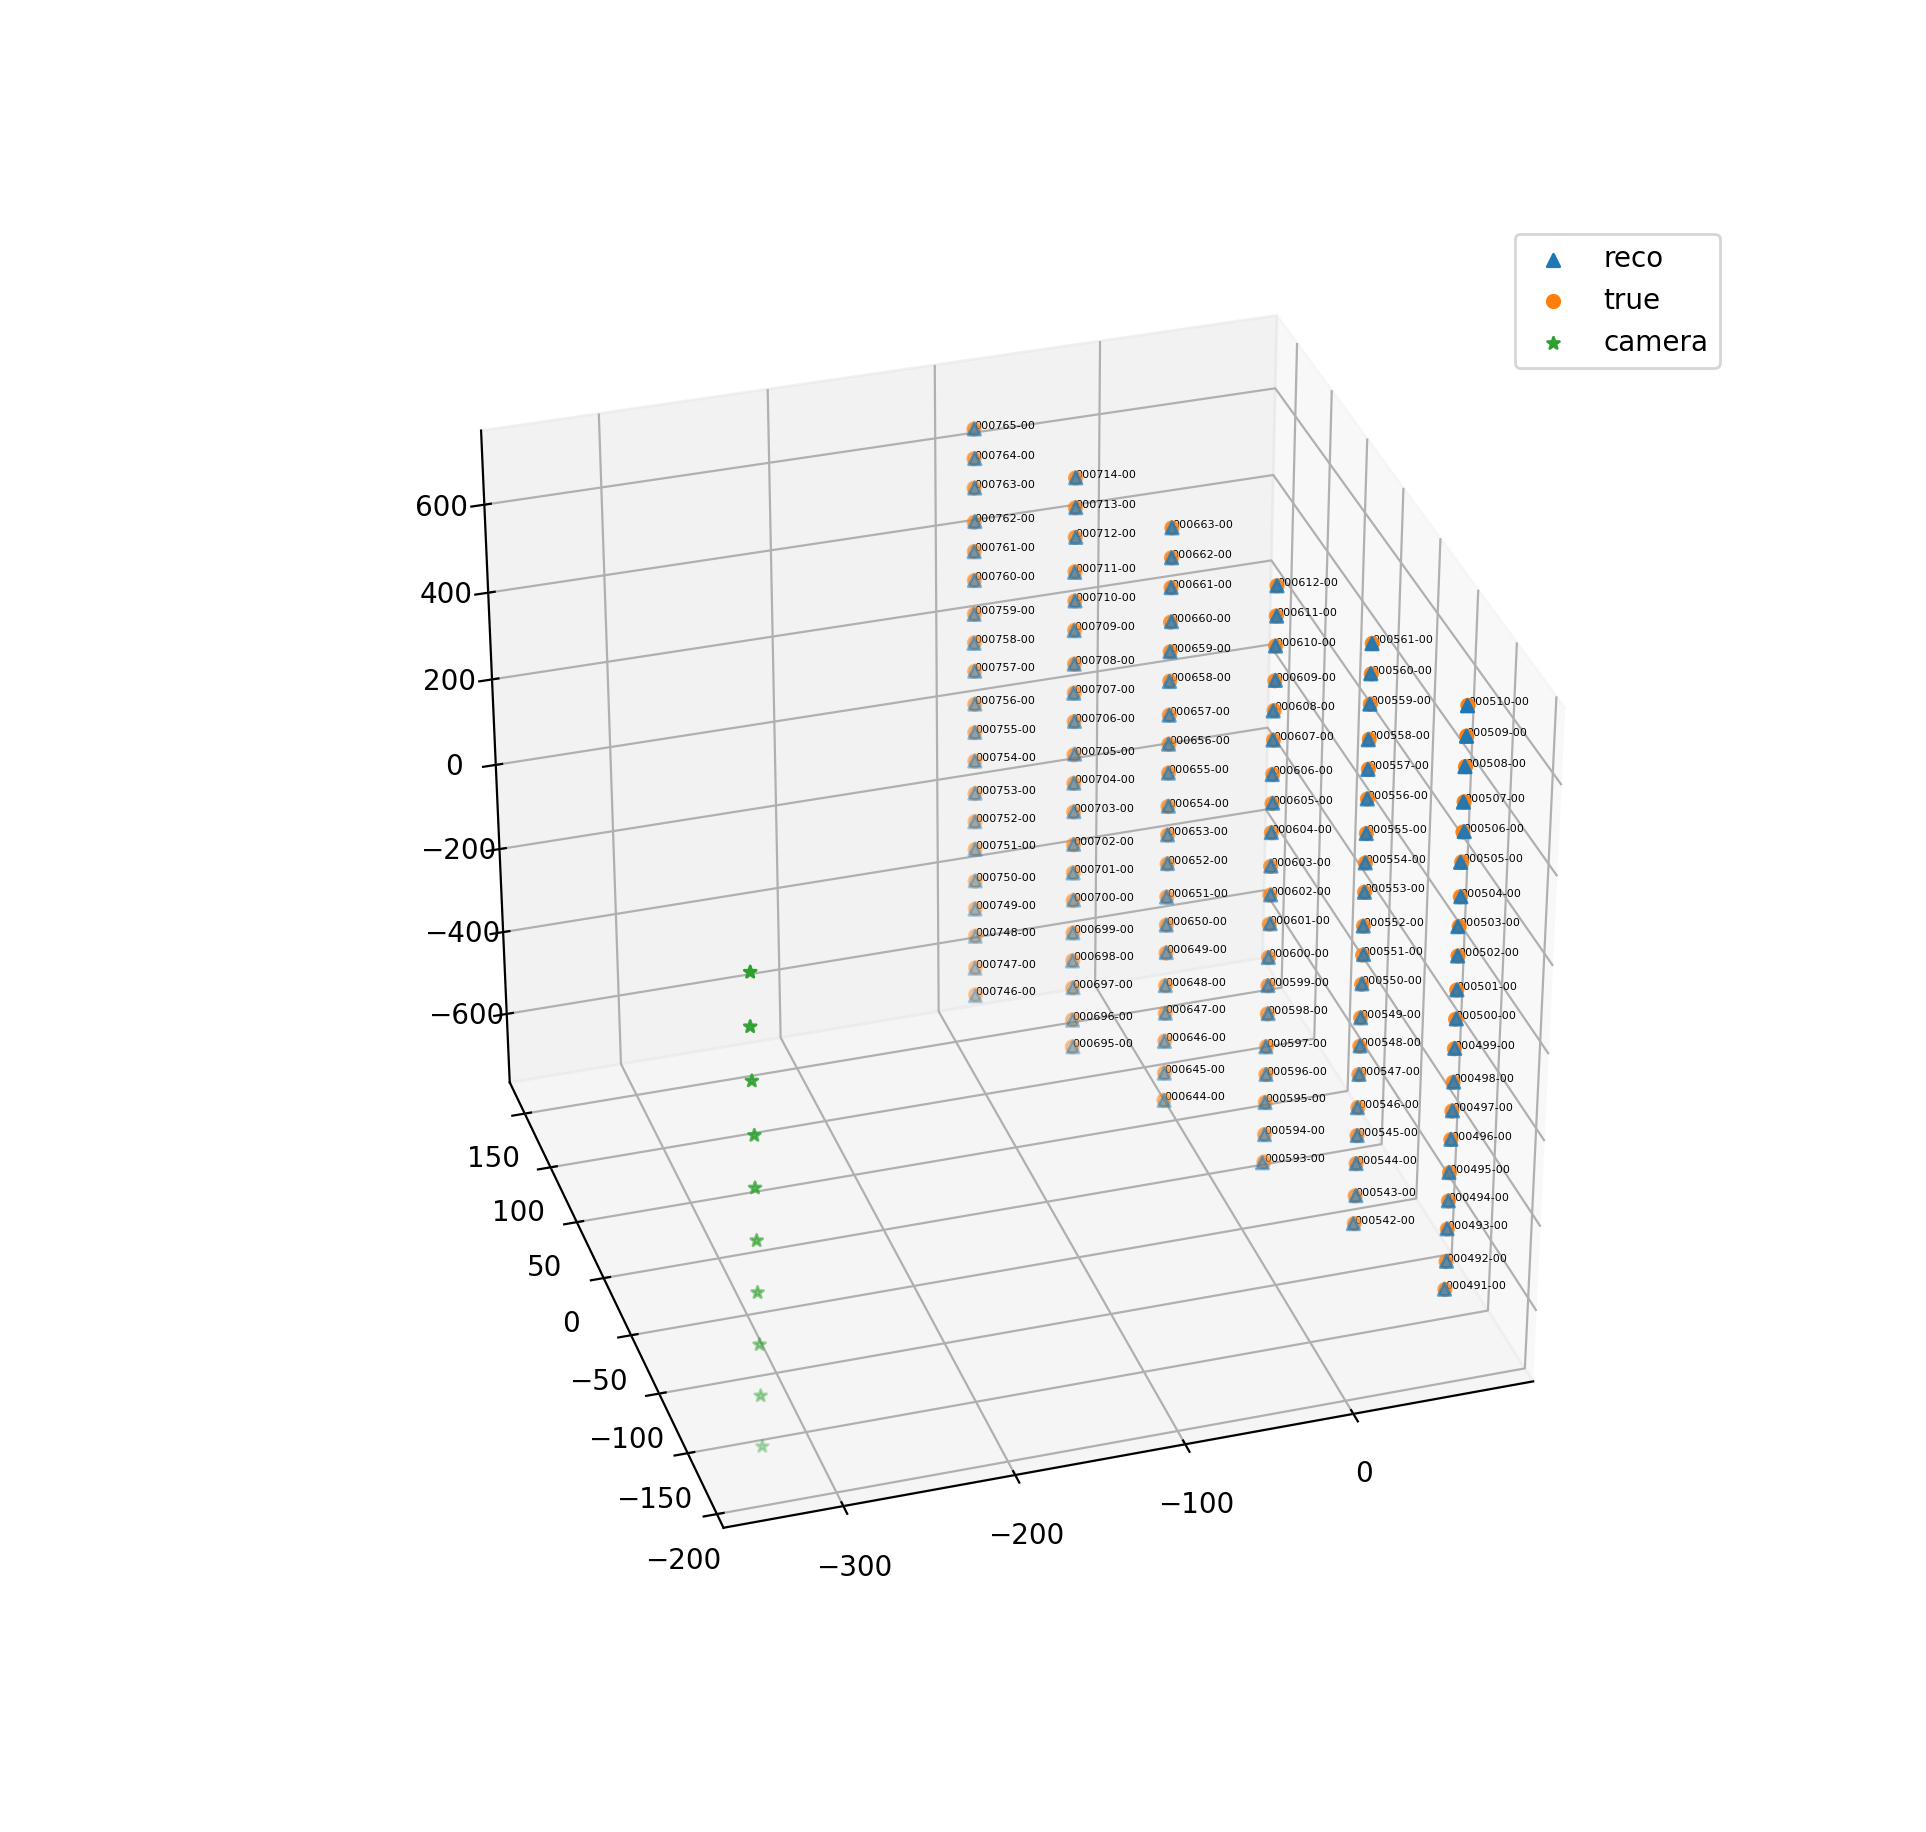

In [15]:
true_array = np.stack(list(common_feature_locations.values()))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reco_transformed[:,0], reco_transformed[:,1], reco_transformed[:,2], marker='^', label="reco")
ax.scatter(true_array[:,0], true_array[:,1], true_array[:,2], marker='o', label="true")
for i, f in enumerate(pmt_locations.keys()):
    ax.text(true_array[i,0], true_array[i,1], true_array[i,2], f, size=4, zorder=1, color='k') 
ax.scatter(camera_positions[:,0], camera_positions[:,1], camera_positions[:,2], marker='*', label="camera")
plt.legend(loc=0)

<IPython.core.display.Javascript object>


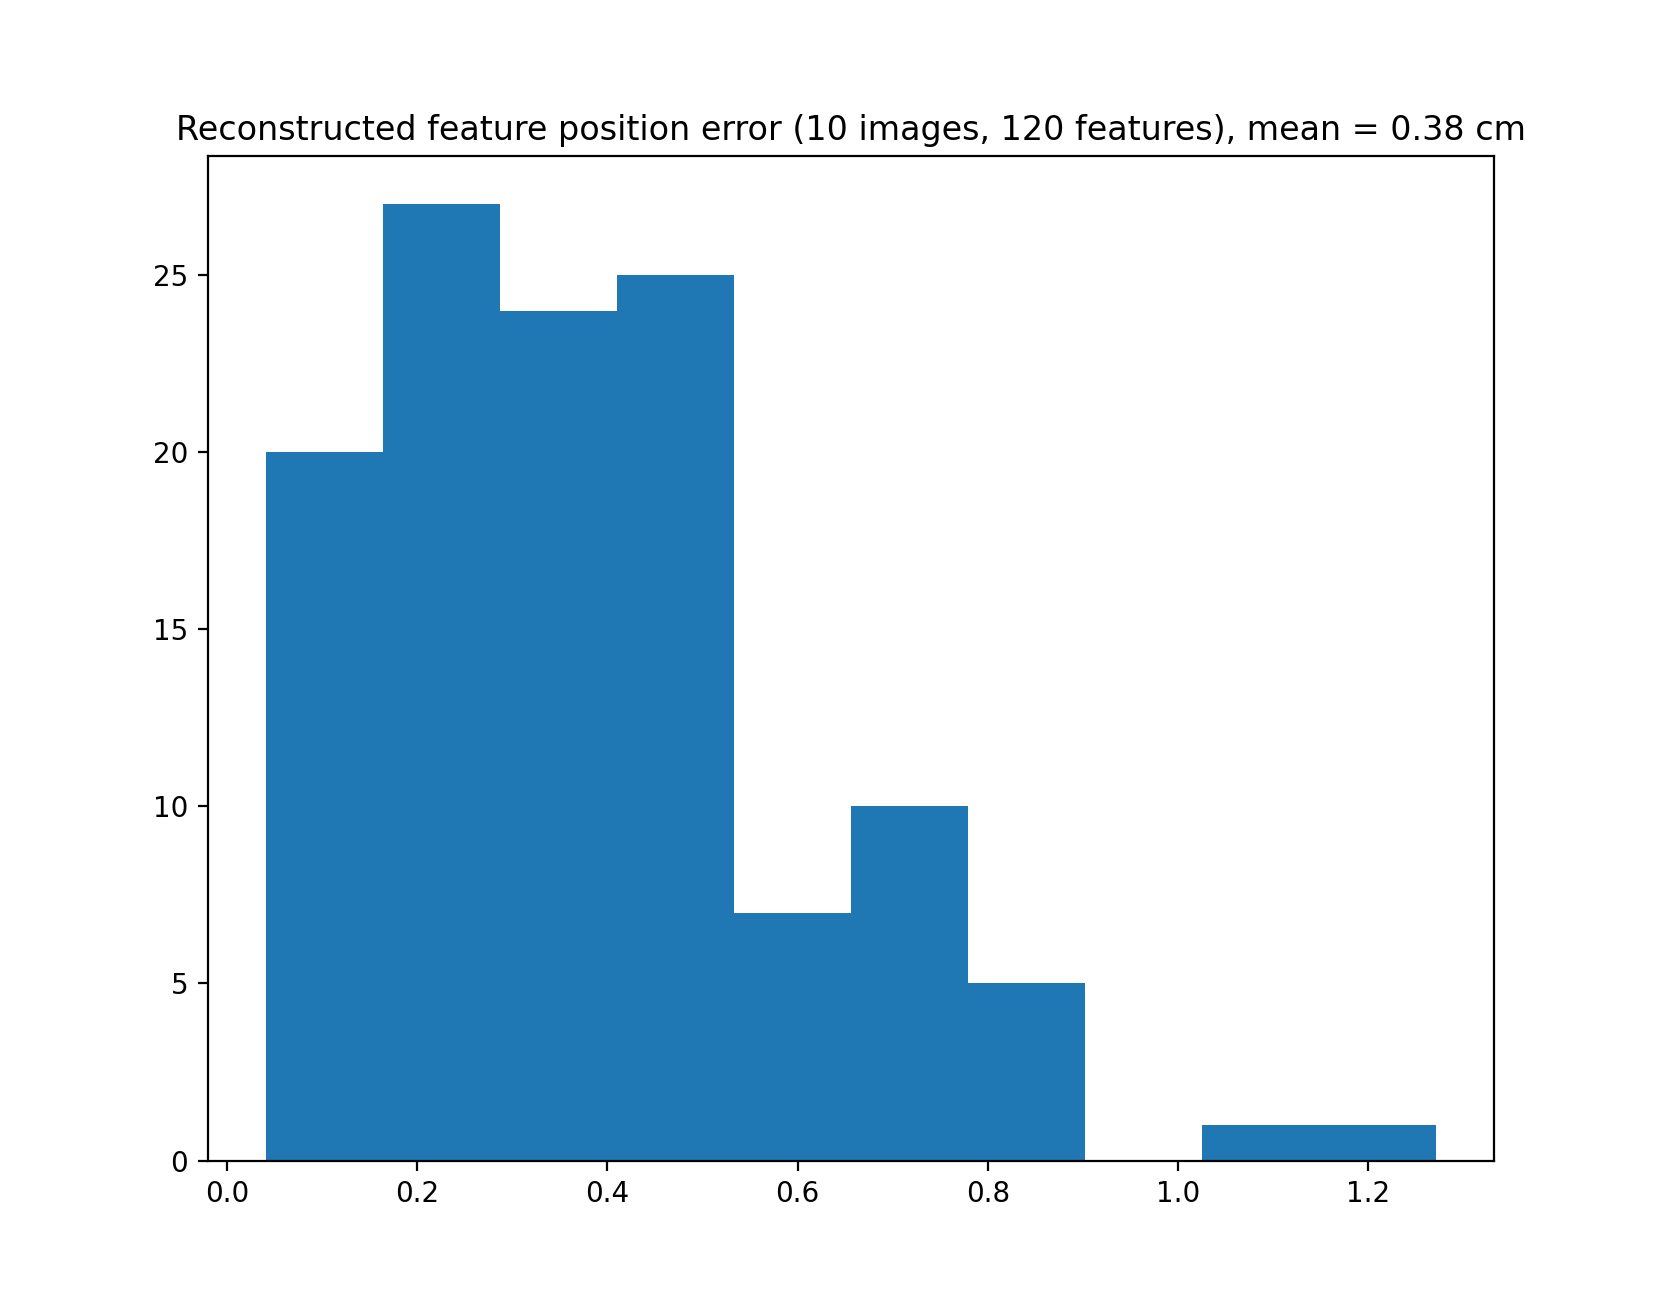

In [16]:
_ = plt.hist(linalg.norm(errors, axis=1), bins='auto')
plt.title("Reconstructed feature position error ({} images, {} features), mean = {:.2f} cm".format(
    nimages, nfeatures, linalg.norm(errors, axis=1).mean()))
plt.show()